In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33937,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.140:46813,Total threads: 4
Dashboard: /proxy/34173/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:41087,


In [3]:
# load the MOM6 data 
db='/g/data/ik11/outputs/mom6-panan/panant.db' 
expts = ['panant-v2','panant-hycom1_v6','panant-01-zstar']

In [4]:
session = cc.database.create_session(db)

In [5]:
# time period
start_time = '1996-01-01'
end_time = '1997-01-01'

In [6]:
# get the depth
depth = cc.querying.getvar('panant-01-zstar','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [7]:
# load MOM6 hmo(x,y,rho,t)
hmo = cc.querying.getvar('panant-01-zstar','hmo',session,start_time=start_time, end_time=end_time)

In [9]:
hmo

,Array,Chunk
Bytes,11.90 GiB,18.77 MiB
Shape,"(15, 70, 845, 3600)","(1, 20, 240, 1025)"
Count,1925 Tasks,960 Chunks
Type,float32,numpy.ndarray


In [10]:
depth = hmo.cumsum(dim='rho2_l').mean('time')

### Now we test different upper layers at differnt depths

In [20]:
# filter 500 m depth
depth_500 = depth.where(depth<500)
# at xh = -10
depth_500 = depth_500.sel(xh = 10.,method = 'nearest').values

In [21]:
# hmo 
flux = hmo.sel(time = slice(start_time,end_time)).sel(xh = 10.,method = 'nearest')

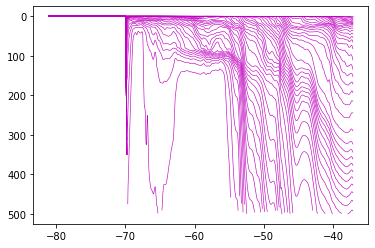

In [24]:
for ii in range(70):
        #if np.mod(ii,10)==5:
        plt.plot(flux.yh.values,depth_500[ii,:],'m',linewidth=0.6)
plt.gca().invert_yaxis()

In [34]:
# load MOM6 umo()
umo = cc.querying.getvar('panant-01-zstar','umo',session,start_time=start_time, end_time=end_time)

# make the coodinates consistent between umo and hmo
umo = umo.sel(xq = slice(-279.91,81.)).rename({'xq': 'xh'}).mean('time')

In [40]:
# umo upper than 500m
flux = umo.where(depth<500)

In [41]:
flux

<xarray.DataArray 'umo' (rho2_l: 70, yh: 845, xh: 0)>
dask.array<where, shape=(70, 845, 0), dtype=float32, chunksize=(20, 240, 0), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 
  * yh       (yh) float64 -81.11 -81.07 -81.02 -80.98 ... -37.3 -37.22 -37.14
  * rho2_l   (rho2_l) float64 1.016e+03 1.033e+03 ... 1.038e+03 1.038e+03